In [1]:
# Build an emulator based on data from all basins
# Investigate different emulator set up and methods
# spatial CV

In [1]:

import sys, os, glob, pickle, toml, json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

sys.path.append("../../MOASMO_support")
from MOASMO_parameters import *

sys.path.append("/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src")
import NSGA2


def get_modified_KGE(obs,sim):
    ind = (~np.isnan(obs)) & (~np.isnan(sim))
    obs = obs[ind]
    sim = sim[ind]

    try:
        sd_sim=np.std(sim, ddof=1)
        sd_obs=np.std(obs, ddof=1)
        m_sim=np.mean(sim)
        m_obs=np.mean(obs)
        r=(np.corrcoef(sim,obs))[0,1]
        relvar=(float(sd_sim)/float(m_sim))/(float(sd_obs)/float(m_obs))
        bias=float(m_sim)/float(m_obs)
        kge=1.0-np.sqrt((r-1)**2 +(relvar-1)**2 + (bias-1)**2)
    except:
        kge = np.nan

    return kge, r, bias, relvar

In [2]:
ncpus = 20 # used for model train (RF can use all cpus; BP-NN can only use 5 for 5-fold cross validation)

# Load data for all basins
From step-1 script

In [3]:
file = 'camels_627basin_allinfo.pkl'

if os.path.exists(file):
    # Load dataframes from the outfile
    with pd.HDFStore(file, 'r') as store:
        df_basin_info = store['df_basin_info']
        df_param_info = store['df_param_info']
        df_att = store['df_att']
else:
    print('File does not exist')

# print('df_basin_info')
# display(df_basin_info.iloc[[0]])

# print('df_param_info')
# display(df_param_info.iloc[[0]])

# print('df_att')
# display(df_att.iloc[[0]])

In [4]:
# model outputs
inpath_moasmo = "/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange"

file_defa_param = 'camels_627basin_ctsm_defa_param.csv'
if os.path.isfile(file_defa_param):
    df_param_defa = pd.read_csv(file_defa_param)
else:
    print('file_defa_param does not exist')

file_all_param = 'camels_627basin_ctsm_all_param.csv.gz'
if os.path.isfile(file_all_param):
    df_param = pd.read_csv(file_all_param, compression='gzip')
else:
    print('file_all_param does not exist')

file_all_metric = 'camels_627basin_ctsm_all_metric.csv.gz'
file_all_basinid = 'camels_627basin_ctsm_all_basinid.csv.gz'

if os.path.isfile(file_all_param):
    df_metric = pd.read_csv(file_all_metric, compression='gzip')
    df_basinid = pd.read_csv(file_all_basinid, compression='gzip')
else:
    print('file_all_param does not exist')

# remove nan values (some failed models)
index = np.isnan(np.sum(df_metric.values, axis=1))
df_param = df_param[~index]
df_metric = df_metric[~index]
df_basinid = df_basinid[~index]

df_param.index = np.arange(len(df_param))
df_metric.index = np.arange(len(df_metric))
df_basinid.index = np.arange(len(df_basinid))

print('Number of nan samples:', np.sum(index))
print("Number of original parameter sets:", len(index))
print("Number of final parameter sets:", len(df_param))

Number of nan samples: 3309
Number of original parameter sets: 250800
Number of final parameter sets: 247491


In [7]:
# # remove basins are that have the lowest kge
# kgestats = np.zeros([len(df_basin_info), 2])
# for i in range(len(df_basin_info)):
#     indi = df_basinid['basin_id'].values == i
#     kgei = df_metric['kge'].values[indi]
#     kgestats[i, 0] = np.nanmax(kgei)
#     kgestats[i, 1] = np.nanmedian(kgei)

# index0 = kgestats[:,0]<0
# index1 = np.where(index0)[0]
# index2 = np.zeros(len(df_basinid))
# for i in range(len(df_basin_info)):
#     if i in index1:
#         indi = df_basinid['basin_id'].values == i
#         index2[indi] = 1


# index = index2==1
# df_param = df_param[~index]
# df_metric = df_metric[~index]
# df_basinid = df_basinid[~index]

# df_param.index = np.arange(len(df_param))
# df_metric.index = np.arange(len(df_metric))
# df_basinid.index = np.arange(len(df_basinid))

# # df_basin_info = df_basin_info[~index0]
# # df_att = df_att[~index0]
# # df_basin_info.index = np.arange(len(df_basin_info))
# # df_att.index = np.arange(len(df_att))

# print('Number of invalid samples:', np.sum(index))
# print("Number of original parameter sets:", len(index))
# print("Number of final parameter sets:", len(df_param))


In [5]:
# Load attributes for training
attlist = toml.load('camels_attributes_fortrain.toml')
att_Xie2021 = attlist['att_Xie2021']

useattrs = list(att_Xie2021.keys())
print("The number of attributes used:", len(useattrs))
print(useattrs)

The number of attributes used: 27
['p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'frac_snow', 'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur', 'mean_elev', 'mean_slope', 'area_gauges2', 'frac_forest', 'lai_max', 'lai_diff', 'dom_land_cover_frac', 'dom_land_cover', 'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity', 'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac', 'carbonate_rocks_frac', 'geol_permeability']


# create model inputs and outputs 
parameters + attributes -> obj funcs

In [6]:
# Prepare model input and output

df_input = df_param.copy()
df_input["hru_id"] = df_basinid["hru_id"]
df_input = df_input.merge(df_att[useattrs + ["hru_id"]], on="hru_id", how="left")
df_input = df_input.drop(["hru_id"], axis=1)

inputnames = list(df_param.columns) + useattrs
# print("Input parameters:", list(df_param.columns))
# print("Input attribuets:",  useattrs)

# if there is string attributes in the input, convert them to one-hot encoding
for att in useattrs:
    if df_input[att].dtype == "object":
        print('convert', att, 'to one-hot encoding')
        enc = OneHotEncoder(sparse=False)
        enc.fit(df_input[[att]])
        encnames = [att + "_" + str(i) for i in range(len(enc.categories_[0]))]
        print('new columns:', encnames)
        df_enc = pd.DataFrame(enc.transform(df_input[[att]]), columns=encnames)
        df_input = pd.concat([df_input, df_enc], axis=1)
        df_input = df_input.drop([att], axis=1)
        inputnames = [i for i in inputnames if i != att] + encnames


# convert to numpy array for training / testing
# print("Input parameters after adjustment:", list(df_param.columns))
# print("Input attribuets after adjustment:",  useattrs)

x_all = df_input[inputnames].values.copy()
print("Input shape:", x_all.shape)

convert dom_land_cover to one-hot encoding
new columns: ['dom_land_cover_0', 'dom_land_cover_1', 'dom_land_cover_2', 'dom_land_cover_3', 'dom_land_cover_4', 'dom_land_cover_5', 'dom_land_cover_6', 'dom_land_cover_7', 'dom_land_cover_8', 'dom_land_cover_9', 'dom_land_cover_10', 'dom_land_cover_11']
Input shape: (247491, 65)


## Outputs

In [7]:
# use normalized kge as output

df_output = df_metric.copy()
y_all = df_output[["kge"]].values.copy()
y_all = y_all / (2 - y_all) # normalize KGE

print("Output shape:", y_all.shape)

Output shape: (247491, 1)


# Train / Test emulators
For train and test, put bad basins aside and then run independent validation

In [12]:
# find bad basins
# remove basins are that have the lowest kge
kgestats = np.zeros([len(df_basin_info), 2])
for i in range(len(df_basin_info)):
    indi = df_basinid['basin_id'].values == i
    kgei = df_metric['kge'].values[indi]
    kgestats[i, 0] = np.nanmin(kgei)
    kgestats[i, 1] = np.nanmedian(kgei)

indexbad = np.where(kgestats[:,0]>0.1)[0]

print('number of bad basins', len(indexbad), len(indexbad)/len(df_basin_info))
print('bad basins', indexbad)

number of bad basins 40 0.06379585326953748
bad basins [213 532 533 534 536 537 541 542 543 544 546 548 550 558 559 563 566 578
 601 602 603 604 605 606 608 609 610 611 612 613 615 616 617 618 619 620
 622 623 624 626]


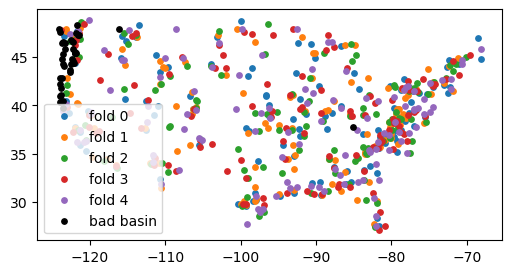

In [13]:
def get_cv_indices(df_basinid, indexbad, nfold=5):
    from sklearn.model_selection import GroupKFold

    index_bad = df_basinid[df_basinid['basin_id'].isin(list(indexbad))].index.tolist()

    # Convert index_bad to a set for faster lookup
    index_bad_set = set(index_bad)
    
    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=nfold)

    # Dictionary to store train and test indices
    cv_indices = {}

    # Cross-validation process to save indices
    # does not depend on random seeds
    for fold, (train_index, test_index) in enumerate(group_kfold.split(df_basinid, groups=df_basinid['basin_num'])):
        
        # Remove all elements in index_bad from train_index and test_index
        train_index = [element for element in train_index if element not in index_bad_set]
        test_index = [element for element in test_index if element not in index_bad_set]
        
        train_basin = np.unique(df_basinid.iloc[train_index]['basin_id'].values)
        test_basin = np.unique(df_basinid.iloc[test_index]['basin_id'].values)

        cv_indices[fold] = {'train_index': train_index, 'test_index': test_index, 'train_basin': train_basin, 'test_basin': test_basin, 'bad_index': index_bad, 'bad_basin': indexbad} 
    return cv_indices

# Get the indices
nfold = 5
cv_indices = get_cv_indices(df_basinid, indexbad, nfold)

# plot test basin batches
fig = plt.figure(figsize=(6, 3))
for fold in range(len(cv_indices)):
    test_basin = cv_indices[fold]['test_basin']
    lat = df_basin_info.iloc[test_basin]['lat_cen'].values
    lon = df_basin_info.iloc[test_basin]['lon_cen'].values
    plt.scatter(lon, lat, 15, label=f'fold {fold}')

lat = df_basin_info.iloc[indexbad]['lat_cen'].values
lon = df_basin_info.iloc[indexbad]['lon_cen'].values
plt.scatter(lon, lat, 15, color='k', label=f'bad basin')

plt.legend()
plt.show()

## Random forest hyperparameter comparison

In [14]:
from sklearn.ensemble import RandomForestRegressor


def get_rmse(d1, d2):
    return ( np.nanmean( (d1-d2)**2 ) ) ** 0.5

def rf_run_cross_validation_parallel(cv_indices, x_all, y_all, ncpus, samplestep, modelconfig={'n_estimators': 100, 'random_state': 42}):

    if True:

        rf_cv_results = {}
        
        # Cross-validation loop
        for fold, indices in cv_indices.items():
        
            # print(f"RF Fold {fold}")
        
            train_index = indices['train_index'][::samplestep]
            test_index = indices['test_index']
            bad_index = indices['bad_index']
            
            x_train, x_test, x_bad = x_all[train_index], x_all[test_index], x_all[bad_index]
            y_train, y_test, y_bad = y_all[train_index], y_all[test_index], y_all[bad_index]
            
            # Initialize a new RandomForestRegressor for each fold
            rf_model = RandomForestRegressor(**modelconfig, n_jobs=ncpus)
            
            # Train the model
            rf_model.fit(x_train, y_train)
        
            # Predict on the test set
            y_test_pred = rf_model.predict(x_test)
            y_bad_pred = rf_model.predict(x_bad)
            y_train_pred = rf_model.predict(x_train)

            if y_test_pred.ndim == 1 and y_test.ndim == 2:
                y_test_pred = y_test_pred[:, np.newaxis]
                y_bad_pred = y_bad_pred[:, np.newaxis]
                y_train_pred = y_train_pred[:, np.newaxis]
            
            
            # Store results
            rf_cv_results[fold] = {
                # 'model': rf_model,
                'train_index': train_index,
                'test_index': test_index,
                'bad_index': bad_index,
                'y_train': y_train,
                'y_test': y_test,
                'y_bad': y_bad,
                'y_test_pred': y_test_pred,
                'y_bad_pred': y_bad_pred,
                'y_train_pred': y_train_pred,
            }
        
    return rf_cv_results


def evaluate_cv_kge(cv_results):
    # evaluation
    kge_test = np.nan * np.zeros([len(cv_results), cv_results[0]['y_train'].shape[1], 4]) #  kge, r, bias, relvar
    kge_train = np.nan * np.zeros([len(cv_results), cv_results[0]['y_train'].shape[1], 4])
    
    for fold in range(len(cv_results)):
        y_train, y_test, y_train_pred, y_test_pred = cv_results[fold]['y_train'], cv_results[fold]['y_test'], cv_results[fold]['y_train_pred'], cv_results[fold]['y_test_pred']
        
        # Evaluate the model using KGE
        for i in range(y_all.shape[1]):
            kge_test[fold - 1, i, :] = get_modified_KGE(y_test[:, i], y_test_pred[:, i])
            kge_train[fold - 1, i, :] = get_modified_KGE(y_train[:, i], y_train_pred[:, i])
    
    for i in [2, 3]:
        kge_test[:,:,i] = kge_test[:,:,i] - 1 # relative bias centering at 0
        kge_train[:,:,i] = kge_train[:,:,i] - 1

    return kge_test, kge_train


def evaluate_cv_rmse(cv_results):
    # evaluation
    rmse_test = np.nan * np.zeros([len(cv_results), cv_results[0]['y_train'].shape[1]])
    rmse_bad = np.nan * np.zeros([len(cv_results), cv_results[0]['y_train'].shape[1]])
    rmse_train = np.nan * np.zeros([len(cv_results), cv_results[0]['y_train'].shape[1]])
    
    for fold in range(len(cv_results)):
        # y_train, y_test, y_train_pred, y_test_pred = cv_results[fold]['y_train'], cv_results[fold]['y_test'], cv_results[fold]['y_train_pred'], cv_results[fold]['y_test_pred']
        y_train, y_test, y_bad, y_train_pred, y_test_pred, y_bad_pred = cv_results[fold]['y_train'], cv_results[fold]['y_test'], cv_results[fold]['y_bad'], cv_results[fold]['y_train_pred'], cv_results[fold]['y_test_pred'], cv_results[fold]['y_bad_pred']

        # Evaluate the model using 
        for i in range(y_all.shape[1]):
            rmse_test[fold - 1, i] = get_rmse(y_test[:, i], y_test_pred[:, i])
            rmse_bad[fold - 1, i] = get_rmse(y_bad[:, i], y_bad_pred[:, i])
            rmse_train[fold - 1, i] = get_rmse(y_train[:, i], y_train_pred[:, i])
            
    return rmse_test, rmse_bad, rmse_train

def load_existing_results(outfile):
    if os.path.exists(outfile):
        with open(outfile, 'r') as file:
            results = json.load(file)
    else:
        results = {}
    return results

def save_results(outfile, results):
    with open(outfile, 'w') as file:
        json.dump(results, file, indent=4)

def config_exists(results, config):
    config_str = json.dumps(config, sort_keys=True)
    return config_str in results

def add_result(results, config, train_rmse, test_rmse):
    config_str = json.dumps(config, sort_keys=True)
    results[config_str] = {
        "train_rmse": train_rmse.tolist(),
        "test_rmse": test_rmse.tolist()
    }

In [45]:
# %%time

# outfile = 'rf_cv_hyperparameter_objfunc_normKGE_removebadbasin.json'

# # Load existing results
# results = load_existing_results(outfile)

# # Model configurations
# modelconfigs = [
#     {'n_estimators': 50, 'random_state': 42, 'max_depth': None},
#     {'n_estimators': 100, 'random_state': 42, 'max_depth': None},
#     {'n_estimators': 100, 'random_state': 42, 'max_depth': 2},
#     {'n_estimators': 100, 'random_state': 42, 'max_depth': 5},
#     {'n_estimators': 100, 'random_state': 42, 'max_depth': 10},
#     {'n_estimators': 100, 'random_state': 42, 'max_depth': 20},
#     {'n_estimators': 100, 'random_state': 42, 'max_depth': 40},
#     {'n_estimators': 100, 'random_state': 42, 'max_depth': 60},
#     {'n_estimators': 200, 'random_state': 42, 'max_depth': None},
#     {'n_estimators': 200, 'random_state': 42, 'max_depth': 10},
#     {'n_estimators': 200, 'random_state': 42, 'max_depth': 20},
# ]

# samplestep = 5
# for modelconfig in modelconfigs:
#     if not config_exists(results, modelconfig):
#         rf_cv_results = rf_run_cross_validation_parallel(cv_indices, x_all, y_all, ncpus, samplestep, modelconfig)
#         rf_rmse_test, rf_rmse_train = evaluate_cv_rmse(rf_cv_results)

#         print(modelconfig)
#         print(np.nanmean(rf_rmse_train, axis=0))
#         print(np.nanmean(rf_rmse_test, axis=0))

#         add_result(results, modelconfig, np.nanmean(rf_rmse_train, axis=0), np.nanmean(rf_rmse_test, axis=0))
#     else:
#         print(f"Configuration {modelconfig} already exists in the results file.")

# # Save updated results
# save_results(outfile, results)

# for i, j in results.items():
#     print(i, j)

## BP NN hyperparameter comparison

In [15]:
from multiprocessing import Pool, cpu_count
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor


def bpnn_run_cross_validation_serial(cv_indices, x_all, y_all, ncpus, outfile):
    if os.path.isfile(outfile):
        with open(outfile, 'rb') as file:
            ann_cv_results = pickle.load(file)
    else:
        ann_cv_results = {}
        
        # Cross-validation loop
        for fold, indices in cv_indices.items():
        
            print(f"BP Fold {fold}")
        
            train_index = indices['train_index'][::samplestep]
            test_index = indices['test_index']
            bad_index = indices['bad_index']
            
            x_train, x_test, x_bad = x_all[train_index], x_all[test_index], x_all[bad_index]
            y_train, y_test, y_bad = y_all[train_index], y_all[test_index], y_all[bad_index]
            
            # Initialize a new MLPRegressor for each fold
            bp_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42, n_iter_no_change=10)
            
            # Train the model
            bp_model.fit(x_train, y_train)
        
            # Predict on the test set
            y_test_pred = bp_model.predict(x_test)
            y_bad_pred = bp_model.predict(x_bad)
            y_train_pred = bp_model.predict(x_train)

            if y_test_pred.ndim == 1 and y_test.ndim == 2:
                y_test_pred = y_test_pred[:, np.newaxis]
                y_bad_pred = y_bad_pred[:, np.newaxis]
                y_train_pred = y_train_pred[:, np.newaxis]
            
            
            # Store results
            ann_cv_results[fold] = {
                # 'model': bp_model,  # Optional: Comment this out to avoid large serialization
                'train_index': train_index,
                'test_index': test_index,
                'bad_index': bad_index,
                'y_train': y_train,
                'y_test': y_test,
                'y_bad': y_bad,
                'y_test_pred': y_test_pred,
                'y_bad_pred': y_bad_pred,
                'y_train_pred': y_train_pred,
            }
        

        with open(outfile, 'wb') as file:
            pickle.dump(ann_cv_results, file)

    return ann_cv_results



# def bpnn_train_and_evaluate_fold(args):
#     fold, indices, x_all, y_all, samplestep, modelconfig = args
#     # print(f"BP Fold {fold}")

#     train_index = indices['train_index'][::samplestep]
#     test_index = indices['test_index']
    
#     x_train, x_test = x_all[train_index], x_all[test_index]
#     y_train, y_test = y_all[train_index], y_all[test_index]
    
#     # Initialize a new MLPRegressor for each fold
#     bp_model = MLPRegressor(**modelconfig)
    
#     # Train the model
#     bp_model.fit(x_train, y_train)

#     # Predict on the test set
#     y_test_pred = bp_model.predict(x_test)
#     y_train_pred = bp_model.predict(x_train)

#     if y_test_pred.ndim == 1 and y_test.ndim == 2:
#         y_test_pred = y_test_pred[:, np.newaxis]
#         y_train_pred = y_train_pred[:, np.newaxis]
    
#     # Store results
#     fold_result = {
#         # 'model': bp_model,  # Optional: Comment this out to avoid large serialization
#         'train_index': train_index,
#         'test_index': test_index,
#         'y_train': y_train,
#         'y_test': y_test,
#         'y_test_pred': y_test_pred,
#         'y_train_pred': y_train_pred,
#     }

#     return fold, fold_result



def bpnn_train_and_evaluate_fold(args):
    fold, indices, x_all, y_all, samplestep, modelconfig = args
    
    train_index = indices['train_index'][::samplestep]
    test_index = indices['test_index']
    bad_index = indices['bad_index']
    
    x_train, x_test, x_bad = x_all[train_index], x_all[test_index], x_all[bad_index]
    y_train, y_test, y_bad = y_all[train_index], y_all[test_index], y_all[bad_index]
            
    
    # Initialize scalers
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()

    # Normalize the input features
    x_train_scaled = x_scaler.fit_transform(x_train)
    x_test_scaled = x_scaler.transform(x_test)
    x_bad_scaled = x_scaler.transform(x_bad)
    
    # Normalize the target values
    y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()
    y_bad_scaled = y_scaler.transform(y_bad.reshape(-1, 1)).flatten()

    # Initialize a new MLPRegressor for each fold
    bp_model = MLPRegressor(**modelconfig)
    
    # Train the model
    bp_model.fit(x_train_scaled, y_train_scaled)

    # Predict on the test set
    y_test_pred_scaled = bp_model.predict(x_test_scaled)
    y_bad_pred_scaled = bp_model.predict(x_bad_scaled)
    y_train_pred_scaled = bp_model.predict(x_train_scaled)

    # Inverse transform the predicted outputs
    y_bad_pred = y_scaler.inverse_transform(y_bad_pred_scaled.reshape(-1, 1)).flatten()
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()

    if y_test_pred.ndim == 1 and y_test.ndim == 2:
        y_bad_pred = y_bad_pred[:, np.newaxis]
        y_test_pred = y_test_pred[:, np.newaxis]
        y_train_pred = y_train_pred[:, np.newaxis]
    

    # Store results
    fold_result = {
                'train_index': train_index,
                'test_index': test_index,
                'bad_index': bad_index,
                'y_train': y_train,
                'y_test': y_test,
                'y_bad': y_bad,
                'y_test_pred': y_test_pred,
                'y_bad_pred': y_bad_pred,
                'y_train_pred': y_train_pred,
            }

    return fold, fold_result



def bpnn_run_cross_validation_parallel(cv_indices, x_all, y_all, ncpus, samplestep, modelconfig={'hidden_layer_sizes': (100,), 'max_iter': 2000, 'alpha': 0.001, 'random_state': 42, 'early_stopping': True}):

    with Pool(processes=ncpus) as pool:
        # Prepare arguments for each fold
        args = [(fold, indices, x_all, y_all, samplestep, modelconfig) for fold, indices in cv_indices.items()]
            
        # Parallelize the cross-validation loop
        results = pool.map(bpnn_train_and_evaluate_fold, args)
        
        # Collect results
        ann_cv_results = {fold: result for fold, result in results}

    return ann_cv_results


In [47]:
# %%time


# outfile = 'bpnn_cv_hyperparameter_objfunc_normKGE_removebadbasin.json'

# # Load existing results
# results = load_existing_results(outfile)

# # Model configurations
# modelconfigs = [
#     {'hidden_layer_sizes': (300,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True},
#     {'hidden_layer_sizes': (200,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True},
#     {'hidden_layer_sizes': (100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True},
#     {'hidden_layer_sizes': (50, 25), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True},
#     {'hidden_layer_sizes': (200,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True, 'learning_rate_init':0.002, 'learning_rate':'adaptive'},
# ]

# samplestep = 2
# for modelconfig in modelconfigs:
#     if not config_exists(results, modelconfig):
#         ann_cv_results = bpnn_run_cross_validation_parallel(cv_indices, x_all, y_all, 5, samplestep, modelconfig)
#         ann_rmse_test, ann_rmse_train = evaluate_cv_rmse(ann_cv_results)
    
#         print(modelconfig)
#         print(np.nanmean(ann_rmse_train,axis=0))
#         print(np.nanmean(ann_rmse_test,axis=0))

#         add_result(results, modelconfig, np.nanmean(ann_rmse_train, axis=0), np.nanmean(ann_rmse_test, axis=0))
#     else:
#         print(f"Configuration {modelconfig} already exists in the results file.")

# # Save updated results
# save_results(outfile, results)

# for i, j in results.items():
#     print(i, j)

In [48]:
%%time

# # compare ann configurations
# modelconfigs = [
#     {'hidden_layer_sizes': (100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True, 'solver': 'adam'},
#     {'hidden_layer_sizes': (100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True, 'solver': 'sgd'},
#     {'hidden_layer_sizes': (100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True, 'solver': 'lbfgs'},
# ]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


## compare RF and ANN

In [16]:
%%time

# choose a model to run and save
outfile = '/glade/work/guoqiang/CTSM_CAMELS/analyses/emulator_comp/allbasin_emulator_rf_normKGE_removegoodbasin.pkl'
samplestep = 1 # used to reduce input sample number (e.g., [::5])

if os.path.isfile(outfile):
# if False:
    with open(outfile, 'rb') as file:
        rf_cv_results = pickle.load(file)
    
else:
    modelconfig = {'n_estimators': 100, 'random_state': 42, 'max_depth': 40}
    rf_cv_results = rf_run_cross_validation_parallel(cv_indices, x_all, y_all, ncpus, samplestep, modelconfig)
    with open(outfile, 'wb') as file:
        pickle.dump(rf_cv_results, file)
    
rf_rmse_test, rf_rmse_bad, rf_rmse_train = evaluate_cv_rmse(rf_cv_results)

print(modelconfig)
print(np.nanmean(rf_rmse_train,axis=0))
print(np.nanmean(rf_rmse_test,axis=0))
print(np.nanmean(rf_rmse_bad,axis=0))

{'n_estimators': 100, 'random_state': 42, 'max_depth': 40}
[0.03048512]
[0.22918356]
[0.31571178]
CPU times: user 42min 25s, sys: 7.24 s, total: 42min 32s
Wall time: 2min 26s


In [17]:
%%time

outfile = '/glade/work/guoqiang/CTSM_CAMELS/analyses/emulator_comp/allbasin_emulator_ann_normKGE_removegoodbasin.pkl'
samplestep = 1 # used to reduce input sample number (e.g., [::5])
# if os.path.isfile(outfile):
if False:
    with open(outfile, 'rb') as file:
        ann_cv_results = pickle.load(file)
else:
    modelconfig = {'hidden_layer_sizes': (200,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True}
    ann_cv_results = bpnn_run_cross_validation_parallel(cv_indices, x_all, y_all, 5, samplestep, modelconfig)
    with open(outfile, 'wb') as file:
        pickle.dump(ann_cv_results, file)

ann_rmse_test, ann_rmse_bad, ann_rmse_train = evaluate_cv_rmse(ann_cv_results)

print(modelconfig)
print(np.nanmean(ann_rmse_train,axis=0))
print(np.nanmean(ann_rmse_test,axis=0))
print(np.nanmean(ann_rmse_bad,axis=0))

{'hidden_layer_sizes': (200,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True}
[0.08571608]
[0.24383227]
[0.32498406]
CPU times: user 4.82 s, sys: 728 ms, total: 5.55 s
Wall time: 1min 19s


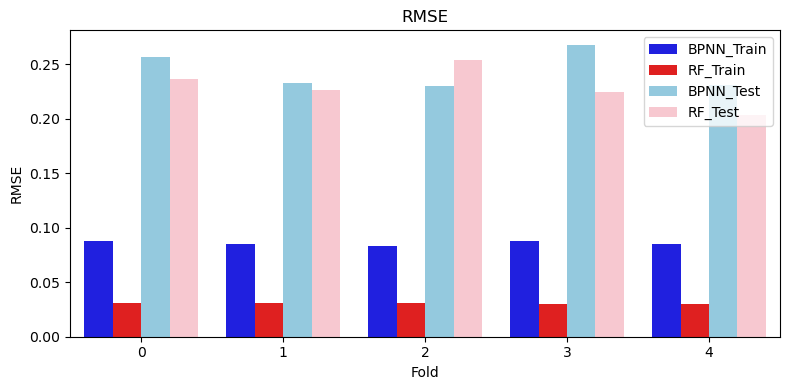

In [18]:
# RMSE-plot
metnames = ["RMSE"]

# Preparing data for seaborn
data = []
folds = np.arange(len(rf_cv_results))

for i in range(1):
    mtrain = ann_rmse_train[:, :].mean(axis=1)
    mtest = ann_rmse_test[:, :,].mean(axis=1)
    mtrainrf = rf_rmse_train[:, :].mean(axis=1)
    mtestrf = rf_rmse_test[:, :,].mean(axis=1)
    
    for fold in folds:
        data.append([fold, mtrain[fold], 'BPNN_Train', metnames[i]])
        data.append([fold, mtrainrf[fold], 'RF_Train', metnames[i]])
        data.append([fold, mtest[fold], 'BPNN_Test', metnames[i]])
        data.append([fold, mtestrf[fold], 'RF_Test', metnames[i]])

df = pd.DataFrame(data, columns=['Fold', 'Value', 'Dataset', 'Metric'])

# Plotting with seaborn
fig = plt.figure(figsize=[8, 4])
palette = {"BPNN_Train": "blue", "BPNN_Test": "skyblue", 
           "RF_Train": "red", "RF_Test": "pink"}

ax = fig.add_subplot(1,1,1)
sns.barplot(x='Fold', y='Value', hue='Dataset', data=df[df['Metric'] == metnames[i]], ax=ax, palette=palette)
ax.set_title(metnames[0])
ax.set_xlabel('Fold')
ax.set_ylabel(metnames[0])
ax.legend()

plt.tight_layout()
plt.show()

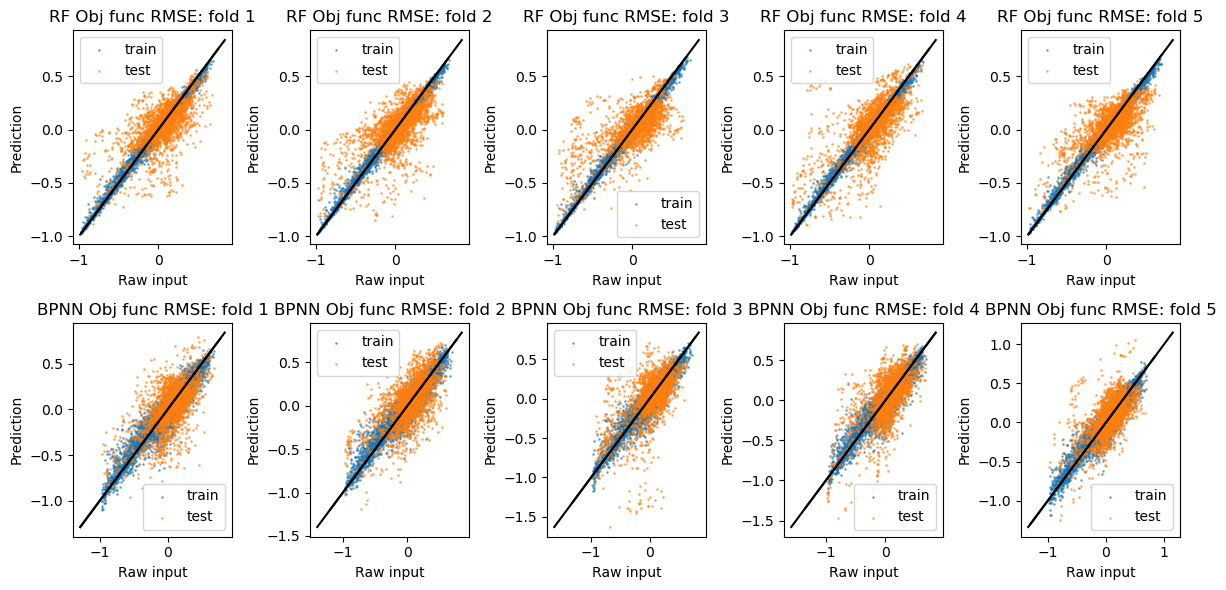

In [22]:
# one obj funcs scatter plots of CV results

cvplot = [rf_cv_results, ann_cv_results]
tp = ['RF', 'BPNN']

fig = plt.figure(figsize=(12, 6))

step=20
markersize=1
flag = 1

for j in range(2):
    for i in range(nfold):
    
        fig.add_subplot(2, 5, flag)

        for t in ['train', 'test']:
            d1, d2 = cvplot[j][i][f'y_{t}'][:,0], cvplot[j][i][f'y_{t}_pred'][:,0]
            
            plt.scatter(d1[::step], d2[::step],markersize,label=t, alpha=0.5)
            lim1, lim2 = min(min(d1), min(d2)), max(max(d1), max(d2))
            plt.plot([lim1, lim2], [lim1, lim2], 'k')
            plt.title(f'{tp[j]} Obj func RMSE: fold {i+1}')
        
        plt.xlabel('Raw input')
        plt.ylabel('Prediction')
        plt.legend()
        
        flag = flag + 1


plt.tight_layout()
plt.show()
